<a href="https://colab.research.google.com/github/AhHosny/CIT690E-DL-Course/blob/master/LAB_2_building_neural_networks_with_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Building Neural Networks with PyTorch

PyTorch provides a number of ways to create different types of neural networks. In this tutorial, we create two types of neural networks for image classification. First one is built using only simple feed-forward neural networks and the second one is Convolutional Neural Network.
In this tutorial we cover:

**1. Dataset**

**2. Building Feed Forward Neural Network with PyTorch**

**3. Building Convolutional Neural Networks with PyTorch**

## 1. Dataset

In this tutorial, we implement neural networks for image classification of the MNIST dataset. So let’s learn a little bit about this dataset.


This dataset is the standard MNIST dataset which is often used as a “Hello world” example. In fact, the MNIST dataset has a training set of 60,000 samples and a testing set of 10,000 images of handwritten digits.

There are 10 classes (digits from 0 to 9). The goal of the neural network is to learn these classes and being able to successfully categorize new images. All images in the dataset have been size-normalized and centered. The size of the images is fixed to 28×28, so the preprocessing image data is minimized.

## 2. Building Feed Forward Neural Networks with PyTorch
Let’s start with the PyTorch implementation of neural networks. First, we need to import all necessary modules:

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

You can see that we are pretty much only using PyTorch modules (except from NumPy and Matplotlib). Using <font color='red'>`nn`</font> module, we are able to create different neural network layers, and using <font color='red'>`nn.functional`</font> we can implement different activation functions. Apart from PyTorch libraries, we use some modules from <font color='red'>`torchvision`</font> library. Namely, we use the MNIST module, which contains MNIST data.

### 2.1 Loading Data with PyTorch

In [3]:
data = MNIST(root='data/', download=True, transform=ToTensor())

validation_size = int(len(data) * 0.2)
train_size = len(data) - validation_size

train_data, val_data = random_split(data, [train_size, validation_size])

batch_size=128
train_loader = DataLoader(train_data, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_data, batch_size*2, num_workers=4, pin_memory=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid poten

Here is what that looks like:

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


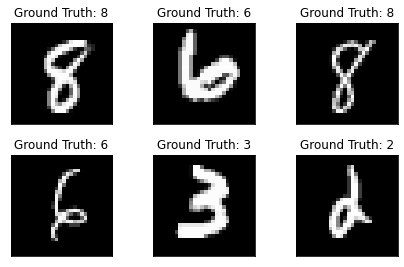

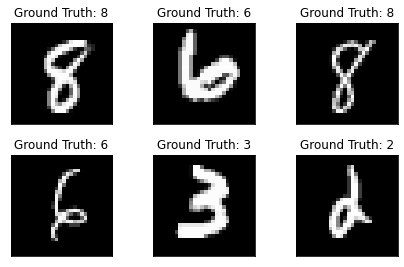

In [4]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

fig

First, we create an object of the MNIST class, which essentially contains all the necessary data. We split this data into training and validation sets. Training data is used during the training process of supervised learning, which is a method neural networks use to learn from the data.

Validation of data is also used during the training process to evaluate how well neural networks perform. Then we use <font color='red'>`DataLoader`</font> class to shuffle data and separate it into batches that are feed to neural networks during each training step.

**Note**: Usually, we would create one test set too, for final evaluation of neural network performance on thus far unseen data, but for this simple tutorial, this is enough.

### 2.2 Feed Forward Neural Network with PyTorch

Essentially, when you want to build some model using PyTorch you can **inherit** <font color='red'>`nn.Module`</font> class. This way you can just by overriding several methods create different types of neural networks.

We utilize that to create a model that receives several parameters through the constructor. It receives **input size** (ie. number of neurons in the input layer), **number hidden layers** and their size, **output size** (ie. number of neurons in the output layer/number of categories), and the **activation function** that is going to be used in each layer.

![ffnn](https://www.3blue1brown.com/content/lessons/2017/neural-networks/output-layer.png)




In [5]:
class FFNN(nn.Module):
    """Simple Feed Forward Neural Network with n hidden layers"""
    def __init__(self, input_size, num_hidden_layers, hidden_size, out_size, accuracy_function):
        super().__init__()
        self.accuracy_function = accuracy_function
        
        # Create first hidden layer
        self.input_layer = nn.Linear(input_size, hidden_size)
        
        # Create remaining hidden layers
        self.hidden_layers = nn.ModuleList()
        for i in range(0, num_hidden_layers):
            self.hidden_layers.append(nn.Linear(hidden_size, hidden_size))
        
        # Create output layer
        self.output_layer = nn.Linear(hidden_size, out_size)
        
    def forward(self, input_image):
        # Flatten image
        input_image = input_image.view(input_image.size(0), -1)
        
        # Utilize hidden layers and apply activation function
        output = self.input_layer(input_image)
        output = F.relu(output)
        
        for layer in self.hidden_layers:
            output = layer(output)
            output = F.relu(output)
        
        # Get predictions
        output = self.output_layer(output)
        return output
    
    def training_step(self, batch):
        # Load batch
        images, labels = batch

        # Get data to cuda if possible
        images = images.to(device=device)
        labels = labels.to(device=device)
        
        # Generate predictions
        output = self(images) 
        
        # Calculate loss
        loss = F.cross_entropy(output, labels)
        return loss
    
    def validation_step(self, batch):
        # Load batch
        images, labels = batch

        # Get data to cuda if possible
        images = images.to(device=device)
        labels = labels.to(device=device)

        # Generate predictions
        output = self(images) 
        
        # Calculate loss
        loss = F.cross_entropy(output, labels)

        # Calculate accuracy
        acc = self.accuracy_function(output, labels)
        
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        
        # Combine losses and return mean value
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        
        # Combine accuracies and return mean value
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch: {} - Validation Loss: {:.4f}, Validation Accuracy: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In order for PyTorch to know that model has certain layers, you need to create a class **attribute** for each layer. That is why we create <font color='red'>`self.input_layer`</font> and <font color='red'>`self.output_layer`</font> attributes.

**Note**: For hidden layers we use a different approach. We create an array of layers with <font color='red'>`nn.ModuleList()`</font>, since this is configurable through num_hidden_layers parameter. For every layer we use <font color='red'>`nn.Linear`</font>, which creates a simple layer with a defined number of neurons. Layers of this type perform simple $y = wx + b$ function.

Apart from this, we need to override one important <font color='red'>`nn.Module`</font> method – **forward**. This function defines how the input will be processed in our neural network. This function basically connects all layers we defined in the constructor. Let’s examine it in more details:

In [6]:
def forward(self, input_image):
	# Flatten image
	input_image = input_image.view(input_image.size(0), -1)
	
	# Utilize hidden layers and apply activation function
	output = self.input_layer(input_image)
	output = F.relu(output)
	
	for layer in self.hidden_layers:
		output = layer(output)
		output = F.relu(output)
	
	# Get predictions
	output = self.output_layer(output)
	return output

First, we **flatten** the image, meaning we reshape it into an array. We do this because the input layer of our neural network can not receive 2D inputs. Then pass this information through each linear layer and apply the rectifier or **ReLu** activation function which is defined with the formula $relu(x) = max(0,x)$. This activation function is most commonly used for hidden layers since it gives the best results.

**Note**: We don’t use ReLu after the output layer. This is because on the output we expect to get **probabilities** for each class.

### 2.3 Training Feed Forward Neural Network with PyTorch

Apart from the forward function, there are various other methods we implement in order to better control the training of the network. Methods **training_step** and **validation_step** define what is done during every training and validation pass:

In [7]:
def training_step(self, batch):
  # Load batch
  images, labels = batch

  # Get data to cuda if possible
  images = images.to(device=device)
  labels = labels.to(device=device)

  # Generate predictions
  output = self(images)

  # Calculate loss
  loss = F.cross_entropy(output, labels)
  return loss

def validation_step(self, batch):
  # Load batch
  images, labels = batch 

  # Get data to cuda if possible
  images = images.to(device=device)
  labels = labels.to(device=device)

  # Generate predictions
  output = self(images) 

  # Calculate loss
  loss = F.cross_entropy(output, labels)

  # Calculate accuracy
  acc = self.accuracy_function(output, labels)

  return {'val_loss': loss, 'val_acc': acc}

The *training_step* function takes the **batch** of images that are provided by the DataLoader and pushes them through the network to get the **prediction**. Underneath, PyTorch uses *forward* function for this. Once this is done, we detect how well the neural network performed by calculating **loss**.

**Note**: The different functions can be used to measure the difference between predicted data and real data. In this example, we use **cross-entropy**.

Method *validation_step* looks similar, but this method also calculates the **accuracy** of our predictions using *accuracy_function* we passed through the constructor and stores loss and returns the dictionary with this information.

Once the validation epoch ends we combine all these into an array, so we can see the history of the training process. Also at the end of every epoch, we print out information *validation_step* returned. Last two functionalities are implemented within *validation_epoch_end* and *epoch_end* methods:

In [8]:
def validation_epoch_end(self, outputs):
	
	# Combine losses and return mean value
	batch_losses = [x['val_loss'] for x in outputs]
	epoch_loss = torch.stack(batch_losses).mean()
	
	# Combine accuracies and return mean value
	batch_accs = [x['val_acc'] for x in outputs]
	epoch_acc = torch.stack(batch_accs).mean()
	return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

def epoch_end(self, epoch, result):
	print("Epoch: {} - Validation Loss: {:.4f}, Validation Accuracy: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In order to automate the **training** process of the neural networks, we implement one more class **ModelTrainer**:

In [9]:
class ModelTrainer():   
  def fit(self, epochs, learning_rate, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), learning_rate)

    for epoch in range(epochs):
        # Training 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation
        result = self._evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history

  def _evaluate(self, model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

This class has two methods **fit** and **_evaluate**. Method **fit** is used for training. It receives a *model*, *number of epochs* (number of times the whole dataset will be passed through the network), *learning rate* and *data loaders*. For each **epoch**, we get batches from the loader and run it through the network by calling the *training_step* method. Then we get the *loss* and use the **backward** method to calculate **gradients**. Finally, we use the **optimizer** to update the **weights** of the network.

Alright, those are the classes that describe the **general** neural network and general training process. We need to get more specific and utilize this class for our problem. To do so, we first need to implement accuracy function:

In [10]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Also, we define helper function for ploting history:

In [11]:
def plot_history(history):
  losses = [x['val_loss'] for x in history]
  plt.plot(losses, '-x')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

  accuracies = [x['val_acc'] for x in history]
  plt.plot(accuracies, '-x')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Loss and Accuracy')

### 2.4 Running it all Together

Finally, we can put all these pieces together and create the object of **FFNN**. We create an neural network with 3 hidden layers and with 32 neurons in each hidden layer. Note that the input size is $28×28=784$ and the output size is 10 since we have 10 digits/classes:

In [12]:
input_size = 784
num_classes = 10
num_hidden_layers = 3

model = FFNN(input_size, num_hidden_layers, 32, out_size=num_classes, accuracy_function=accuracy).to(device)
print(model)

FFNN(
  (input_layer): Linear(in_features=784, out_features=32, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=32, bias=True)
  )
  (output_layer): Linear(in_features=32, out_features=10, bias=True)
)


Let’s train it and plot the history and accuracy:

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 0 - Validation Loss: 0.3690, Validation Accuracy: 0.8984
Epoch: 1 - Validation Loss: 0.2127, Validation Accuracy: 0.9395
Epoch: 2 - Validation Loss: 0.1759, Validation Accuracy: 0.9481
Epoch: 3 - Validation Loss: 0.1617, Validation Accuracy: 0.9525
Epoch: 4 - Validation Loss: 0.1672, Validation Accuracy: 0.9533


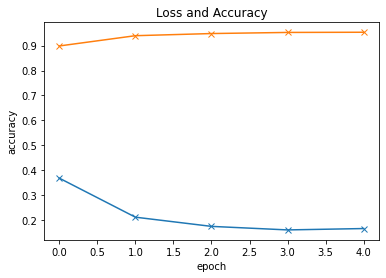

In [13]:
model_trainer = ModelTrainer()

training_history = []
training_history = model_trainer.fit(5, 0.2, model, train_loader, val_loader)

plot_history(training_history)

Notice how loss is getting lower and the accuracy is getting better. In the end after only 5 epochs we reached accuracy of 96%.

## 3. Building Convolutional Neural Networks with PyTorch

If you want to process and classify images one of the best ways to do so is by using **Convolutional Neural Networks**. This type of network is in a way responsible for deep learning hype in the past couple of years. In the end, they use feed-forward neural networks, but they have a couple of tricks for image processing.

At its core, we can find the **convolution** process. This process is used for making detecting features of the images and uses this information for classification. Here is how the complete **architecture** of Convolutional Neural Networks looks like:

![cnn](https://miro.medium.com/max/3744/1*SGPGG7oeSvVlV5sOSQ2iZw.png)

First, **convolution** layers detect features (line, curve, etc) of the image using filters. They create so-called **feature maps** that contain information about where in the image certain feature is located. These maps are further compressed by the **pooling** layers after which are **flattened** into 1D array. Finally, a feed-forward network is used for classification, which is in this context called **fully connected**.

PyTorch <font color='red'>`nn`</font> module provides a number of other layer trypes, apart from the Linear that we already used. Here is how we can implement the process described above:

In [17]:
class CNN(nn.Module):
    """Simple Convolutional Neural Network"""
    def __init__(self, accuracy_function):
        super().__init__()
        self.accuracy_function = accuracy_function

        # Create Convolutional Layers
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        # Create Max Pooling Layer
        self.max_pool2d = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        # Create Fully Connected Layers
        self.fc1 = nn.Linear(7*7*64, 128) 
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, input_image):
        # Convolution, ReLu and MaxPooling
        output = self.conv1(input_image)
        output = F.relu(output)
        output = self.max_pool2d(output)

        output = self.conv2(output)
        output = F.relu(output)
        output = self.max_pool2d(output)

        # Flatten
        output = output.view(-1, self.num_flat_features(output))
        
        # Fully Connected
        output = self.fc1(output)
        output = F.relu(output)
        output = self.fc2(output)

        return output
    
    def training_step(self, batch):
        # Load batch
        images, labels = batch
        
        # Get data to cuda if possible
        images = images.to(device=device)
        labels = labels.to(device=device)

        # Generate predictions
        output = self(images) 
        
        # Calculate loss
        loss = F.cross_entropy(output, labels)
        return loss
    
    def validation_step(self, batch):
        # Load batch
        images, labels = batch

        # Get data to cuda if possible
        images = images.to(device=device)
        labels = labels.to(device=device)

        # Generate predictions
        output = self(images) 
        
        # Calculate loss
        loss = F.cross_entropy(output, labels)

        # Calculate accuracy
        acc = self.accuracy_function(output, labels)
        
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        
        # Combine losses and return mean value
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        
        # Combine accuracies and return mean value
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch: {} - Validation Loss: {:.4f}, Validation Accuracy: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
        
    def num_flat_features(self, image):
        size = image.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
            
        return num_features

he difference from **FFNN** are located in the *constructor* and the *forward* method. We know upfront which layers we want to use and we add two convolutional layers using <font color='red'>`conv2d`</font> class and two fully connected layers using <font color='red'>`linear`</font> class like before.

In the **forward** function we use <font color='red'>`max_pool2d`</font> function to perform max pooling. Other methods are the same as for the FFNN implementation. We can utilize **ModelTrainer** that we already implemented before and train this network:

In [18]:
input_size = 784
num_classes = 10

model = CNN(accuracy_function=accuracy).to(device)
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 0 - Validation Loss: 0.1013, Validation Accuracy: 0.9683
Epoch: 1 - Validation Loss: 0.0792, Validation Accuracy: 0.9758
Epoch: 2 - Validation Loss: 0.0635, Validation Accuracy: 0.9808
Epoch: 3 - Validation Loss: 0.0614, Validation Accuracy: 0.9814
Epoch: 4 - Validation Loss: 0.0575, Validation Accuracy: 0.9829


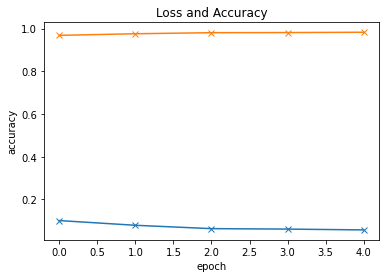

In [19]:
model_trainer = ModelTrainer()

training_history = []
training_history += model_trainer.fit(5, 0.2, model, train_loader, val_loader)

plot_history(training_history)

We got a bit better results than with feed-forward neural networks. Accuracy is 98%. We can further improve these results by adding more convolutional layers, training networks longer, and modify the learning late. Give it a try.

### End of notebook.